# CRISP-DM of Airbnb Seattle Data.
1. [Business Section](#Business_Understanding) - Goal of exploration.

2. [Data Understanding](#Data_Understanding) - Investigating Data characteristics.

3. Data Preparation - Cleaning data for use. Distributed among questions.

4. Modeling - Putting data into models for insight. Distributed among questions.

5. [Evaluation](#Evaluation) - Overall takeaways.


## Business Understanding <a id='Business_Understanding'></a>
The end goal of Airbnb as a business is to have more people using their services. The questions I pose are tailored towards what someone should look for when starting a new Airbnb listing.
1. [Are there bad locations for Airbnb listings?](#Q1)
2. [What is the average price of an Airbnb listing per neighborhood?](#Q2)
3. [What quantitative features affect Airbnb price?](#Q3)

## Data Understanding <a id='Data_Understanding'></a>
Exploration of data.

In [965]:
# Module imports for use in this notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import collections

In [966]:
# Importing the Seattle Airbnb data about the listings. Only this data will be used in this analysis.
df = pd.read_csv('seattle\listings.csv')

In [967]:
# Looking at the data size
print(df.shape)
df.head(2)

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [968]:
# Looking specifically at the features
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Text(0.5, 1.0, 'Missing Values')

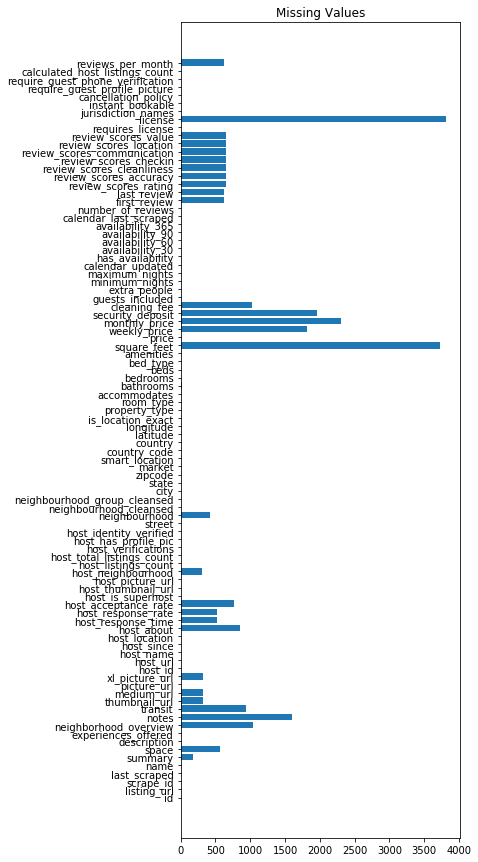

In [969]:
# Looking at missing data
fig, ax = plt.subplots(figsize=(5,15))
ax.barh(width=df.isnull().sum().values, y=df.isnull().sum().index);
plt.title('Missing Values')

In [970]:
# Looking at the data types. Will mostly use the numerical data. 
df.dtypes.value_counts()

object     62
float64    17
int64      13
dtype: int64

## Are there bad locations for Airbnb listings? <a id='Q1'></a>
The lowest rated 10% of listing will be considered "bad" listings. It should be noted that without further investigation into some sort of sentiment analysis on the comments and ratings, it's hard to tell if the lowest rated 10% of listings are truly undesireable.

1. [How are "bad" listings distributed?](#Q1.1)
2. [What is the "worst" neighborhood?](#Q1.2)
3. [Are bad listing clustered near eachother?](#Q1.3)

[Insights](#T1)

In [971]:
# Finding the bottom 10% of listings. 
quantile = 0.1
quantile_rating = df['review_scores_rating'].quantile(quantile)
above_quantile = df.query('review_scores_rating > review_scores_rating.quantile(@quantile)').shape[0]
below_quantile = df.query('review_scores_rating < review_scores_rating.quantile(@quantile)').shape[0]

print('{:.0f}% Percentile Rating: '.format(quantile * 100), quantile_rating)
print('Listing Above Percentile: ', above_quantile)
print('Listings Below Percentile: ', below_quantile)


10% Percentile Rating:  87.0
Listing Above Percentile:  2845
Listings Below Percentile:  271


### Visualizing the distribution of "good" and "bad" listings. <a id='Q1.1'></a>

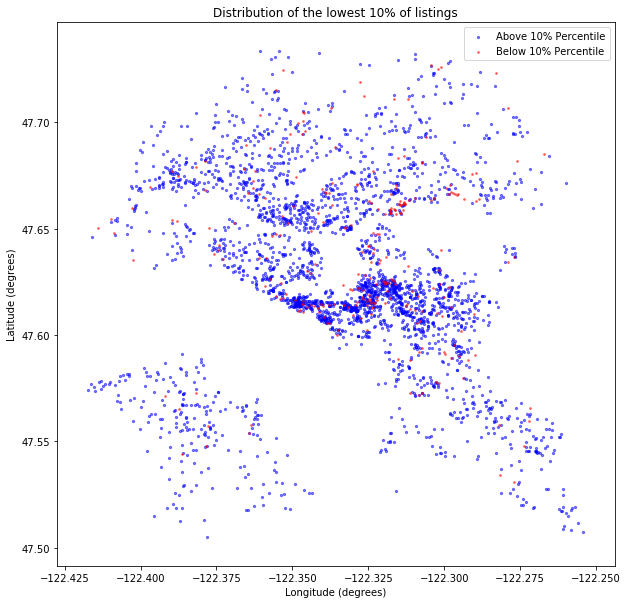

In [972]:
# Using the determined review_scores_rating cutoff to visualize the "good" and "bad" listings.
bad_rat = df.query('review_scores_rating < review_scores_rating.quantile(@quantile)')[['latitude', 'longitude']]
good_rat = df.query('review_scores_rating > review_scores_rating.quantile(@quantile)')[['latitude', 'longitude']]
fig = plt.figure(figsize=(10,10))
plt.scatter(x=good_rat.longitude, y=good_rat.latitude, s=5, c='blue', alpha=0.5)
plt.scatter(x=bad_rat.longitude, y=bad_rat.latitude, s=3, c='red', alpha=0.5)
plt.legend(['Above {:.0f}% Percentile'.format(quantile * 100), 'Below {:.0f}% Percentile'.format(quantile * 100)])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Distribution of the lowest 10% of listings')
plt.show()

### Investigation of the "worst" neighborhood - Ravenna <a id='Q1.2'></a>

In [973]:
# Using the bottom 10% of neighborhoods to find the lowest ranked neighborhoods.
neighborhood_ratings = df.groupby('host_neighbourhood')['review_scores_rating'].mean()
worst_neighborhoods = neighborhood_ratings[neighborhood_ratings < quantile_rating]
print(worst_neighborhoods)

host_neighbourhood
Fenway/Kenmore    67.500000
Pinehurst         84.000000
Ravenna           86.642857
Name: review_scores_rating, dtype: float64


In [974]:
# Want to use neighborhoods with a large number of reviews. Can see below that Fenway/Kenmore and Pinehurst
#    very few reviews.
neighborhoods = df.groupby('host_neighbourhood')['number_of_reviews'].sum()
print(neighborhoods[worst_neighborhoods.index])

host_neighbourhood
Fenway/Kenmore       6
Pinehurst            5
Ravenna           1468
Name: number_of_reviews, dtype: int64


count     84.000000
mean      86.642857
std       12.947198
min       53.000000
25%       79.500000
50%       90.500000
75%       98.000000
max      100.000000
Name: review_scores_rating, dtype: float64


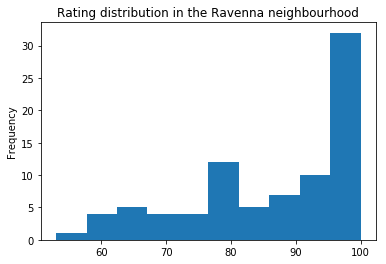

In [975]:
# Looking at Ravenna for some more information
Ravenna = df.query('host_neighbourhood == "Ravenna"')
print(Ravenna.describe()['review_scores_rating'])
# Plotting the distribution of ratings in Ravenna
Ravenna['review_scores_rating'].plot(kind='hist', title='Rating distribution in the Ravenna neighbourhood');

### Visualizing just the Ravenna ratings

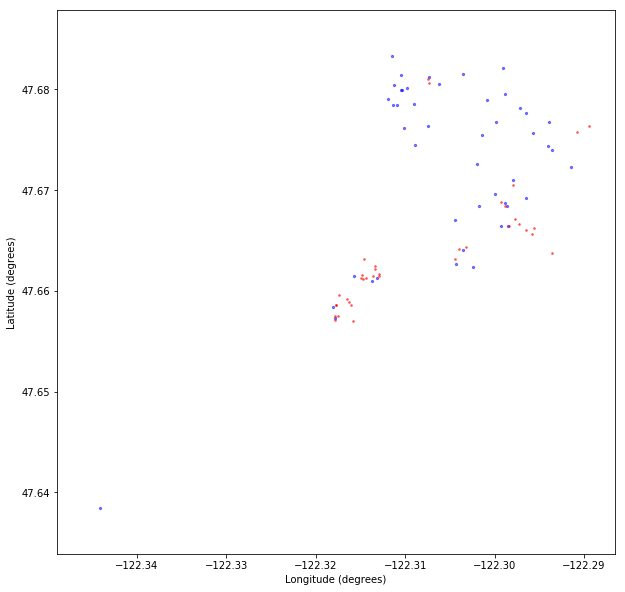

In [976]:
R_bad_rat = Ravenna.query('review_scores_rating <= @quantile_rating')[['latitude', 'longitude']]
R_good_rat = Ravenna.query('review_scores_rating > @quantile_rating')[['latitude', 'longitude']]
fig = plt.figure(figsize=(10,10))
plt.scatter(x=R_good_rat.longitude, y=R_good_rat.latitude, s=5, c='blue', alpha=0.5)
plt.scatter(x=R_bad_rat.longitude, y=R_bad_rat.latitude, s=3, c='red', alpha=0.5)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

### Visualizing clusters of "bad" ratings ot more clearly see density of "bad" ratings. <a id='Q1.3'></a>
DBSCAN is used to find when there are 3 or more listings within approximately 1/10th of a mile of eachother. A degree of longitude is not exactly equivalent to 60 miles at this latitude but it is roughly representative.

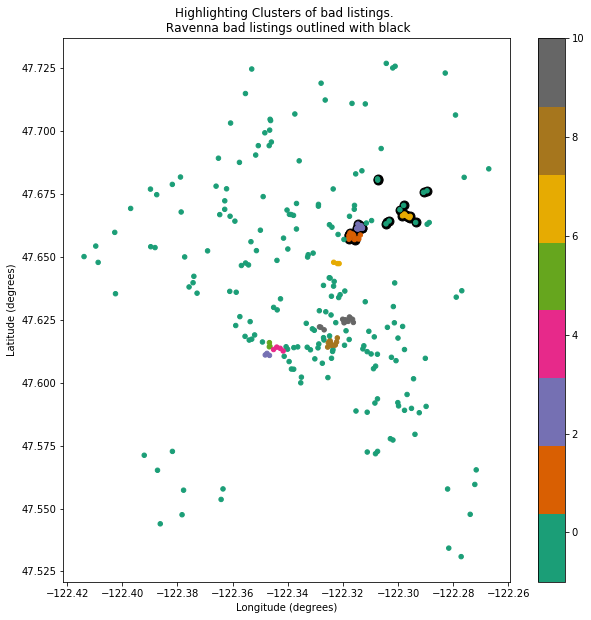

In [977]:
# What is one mile approximately equivalent to in latitude and longitude 
one_mile = 1/60 # 60 miles in a degree of latitude

# Looking for clusters of 3 "bad" listings within approximately 1/10th of a mile spacing.
dbscan = DBSCAN(eps=one_mile/10, min_samples=3)
bad_rat = df.query('review_scores_rating < review_scores_rating.quantile(@quantile)')[['latitude', 'longitude']]
clusters = dbscan.fit_predict(bad_rat)

# Plotting the "bad" listings with groupings given different colors. The Ravenna listings are outlined with black.
plt.figure(figsize=(10,10))
plt.scatter(x=R_bad_rat.longitude, y=R_bad_rat.latitude, c='black',s=80, alpha=1)
plt.scatter(x=bad_rat.longitude, y=bad_rat.latitude, cmap='Dark2', c=clusters, s=20)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.colorbar()
plt.title('Highlighting Clusters of bad listings. \n Ravenna bad listings outlined with black')
plt.show()

### Insights from "bad" listing location clustering. <a id='T1'></a>
1. There are clusters of "bad" listings that are not apparently noticeable when looking at the overall visualization of "good" and "bad" listings.
2. "Bad" lastings appear to be fairly spread out. Without insights on population density or a deep dive into neighborhood characteristics it is hard to say what is causing the clusters of "bad" listings.

Further analysis:
1. Look at "bad" listing density compared to population. This analysis would require additional data with general city statistics.
2. Do sentiment analysis on the data with the written reviews and given score. Would help to determine what it means for a listing to be "bad".
3. Analysis of characteristics of the "bad" locations.

## What is the average price of an Airbnb listing per neighborhood? <a id='Q2'></a>
Looking at price distribution based on location. Excluding outliers above 3 standard deviations above the mean.
1. [Visualization of weekly price of listings](#Q2.1)
2. [Visualization of weekly price averages based on neighborhood](#Q2.2)
3. [Visualization of the top 10 most expensive neighborhoods](#Q2.3)

[Insights](#T2)

In [978]:
# Clean weekly price strings into floats for usage
df_prices = df.copy()
df_price = df['weekly_price'].dropna()
df_ps = df_price.apply(lambda x: float(x.replace('$','').replace(',','')))
df_prices['weekly_price'] = df_ps

In [979]:
# Quick look at the weekly_price distributions
df_prices['weekly_price'].describe()

count    2009.000000
mean      788.481832
std       532.352269
min       100.000000
25%       455.000000
50%       650.000000
75%       950.000000
max      6300.000000
Name: weekly_price, dtype: float64

In [980]:
# Remove outliers 3 standard deviations above the mean
df_rem = df_prices[df_prices['weekly_price'] < (df_prices['weekly_price'].mean()+df_prices['weekly_price'].std()*3)]

## Visualization of weekly price of listings <a id='Q2.1'></a>

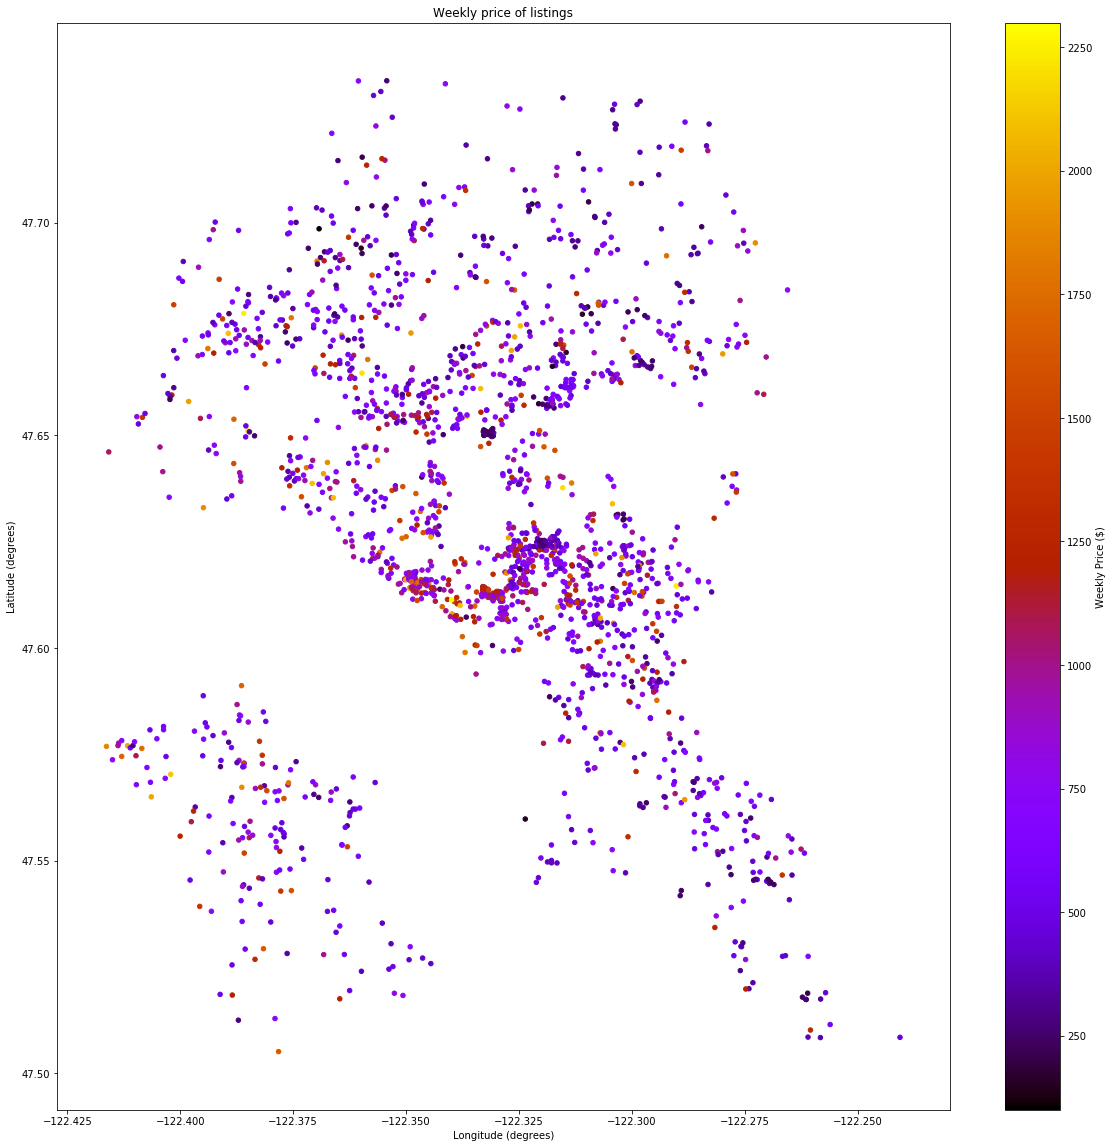

In [981]:
plt.figure(figsize=(20,20))
plt.scatter(x=df_rem['longitude'], y=df_rem['latitude'], c=df_rem['weekly_price'], cmap='gnuplot',s=20)
plt.colorbar(label='Weekly Price ($)')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Weekly price of listings')
plt.show()

## Visualization of weekly price averages based on neighborhood <a id='Q2.2'></a>

In [982]:
# Finding location and weekly_price based on neighborhood averages.
neighborhood_cost = df_prices.groupby('host_neighbourhood')[['weekly_price', 'latitude', 'longitude']].mean()

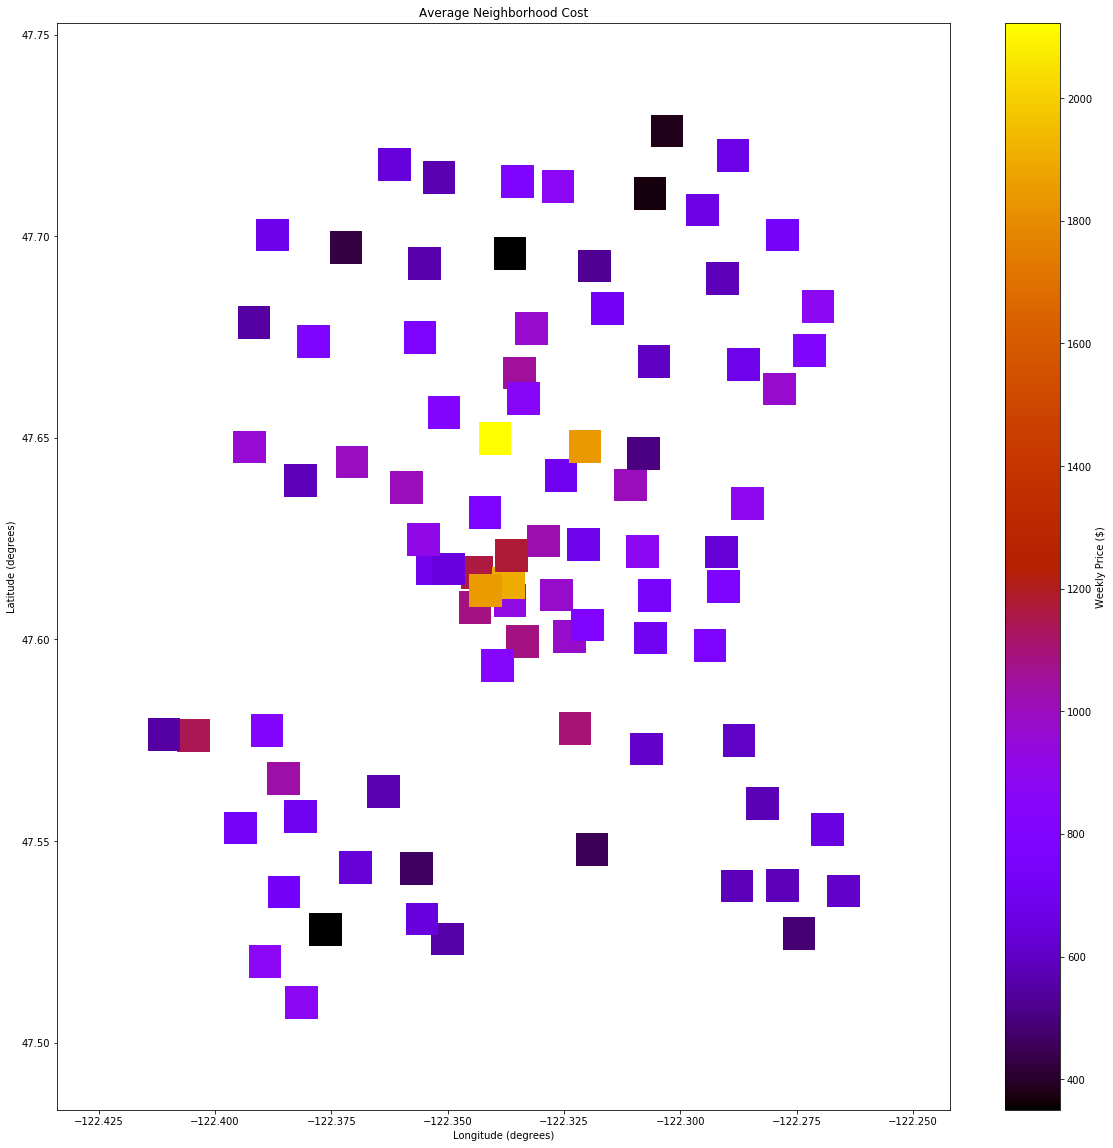

In [983]:
plt.figure(figsize=(20,20))
plt.scatter(x=neighborhood_cost['longitude'], y=neighborhood_cost['latitude'], 
            marker='s', c=neighborhood_cost['weekly_price'], cmap='gnuplot',s=1000)
plt.colorbar(label='Weekly Price ($)')
plt.title('Average Neighborhood Cost')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

## Top most expensive neighborhoods based on average weekly price <a id='Q2.3'></a>


In [984]:
# Finding the top most expensive neighborhoods
top_cost = neighborhood_cost['weekly_price'].sort_values(ascending=False).head(10)

In [985]:
# Visualizing the top 10
neighborhood_cost.loc[top_cost.index]

,weekly_price,latitude,longitude
host_neighbourhood,,,
Kaanapali,2123.000000,47.650008,-122.339926
Fenway/Kenmore,1900.000000,47.614154,-122.337092
Pike Place Market,1850.000000,47.612224,-122.341921
Portage Bay,1841.666667,47.648038,-122.320575
South Lake Union,1176.636364,47.620876,-122.336332
Belltown,1161.461538,47.616740,-122.343779
Alki,1144.785714,47.576293,-122.404769
Industrial District,1100.000000,47.578095,-122.322707
Anaheim,1086.250000,47.607982,-122.344190


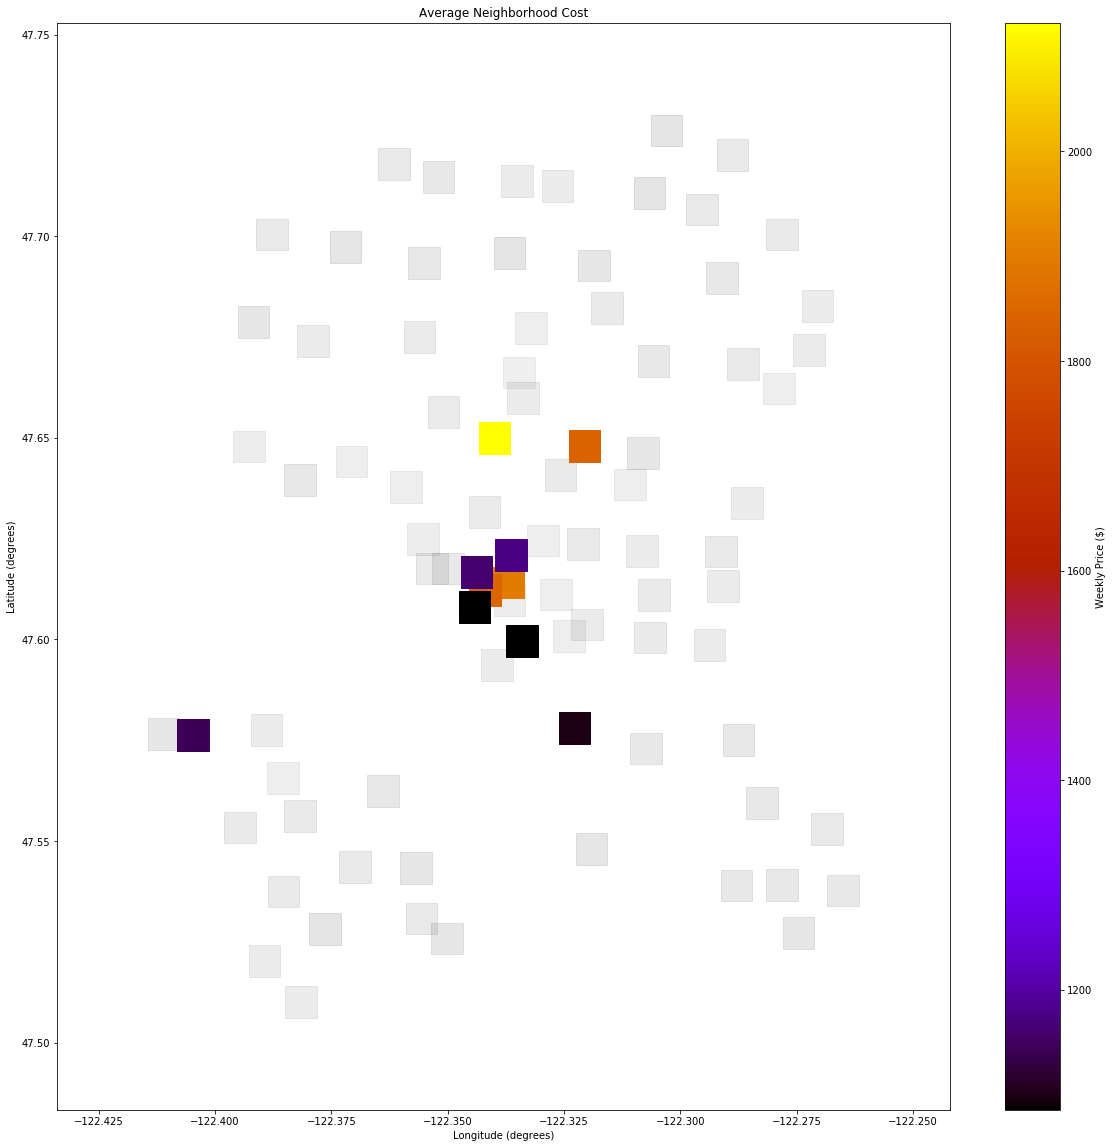

In [986]:
# Plotting the top 10 and also the rest of the neighborhood locations for reference
plt.figure(figsize=(20,20))
plt.scatter(x=neighborhood_cost['longitude'], y=neighborhood_cost['latitude'],
            marker='s', c=neighborhood_cost['weekly_price'], cmap='gray',s=1000,alpha=0.1)
plt.scatter(x=neighborhood_cost.loc[top_cost.index]['longitude'], y=neighborhood_cost.loc[top_cost.index]['latitude'],
            marker='s', c=neighborhood_cost.loc[top_cost.index]['weekly_price'], cmap='gnuplot',s=1000)
plt.colorbar(label='Weekly Price ($)')
plt.title('Average Neighborhood Cost')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

## Insights on pricing by location <a id='T2'></a>
1. Can see that most of average highest cost is in a central area. 
2. Looking at the map of all the listing costs, can see that more expensive listings are scattered throughout Seattle.
3. If able to start a new Airbnb listing, can use the above visualizations to determine optimal areas.

    
Further Investigation:
1. Would be interesting to see how prices change over time to match supply and demand. Possibly in the other Seattle Airbnb data set.
2. Further detail on what defines the highest cost areas. Is the higher cost of rental due to a higher cost of owning a home in those areas? Is there an acceptable return on investment?
3. Do the same analysis for Monthly_price and see if there are any differences.

## What quantitative features affect Airbnb price? <a id='Q3'></a>
Using a random forest regressor to see what quantitative features are the most important in predicting cost.

1. [Feature importance](#Q3.1)

[Insights](#T3)

In [987]:
# Clean weekly price strings into floats for usage
df_cop = df.copy()
df_price = df_cop['weekly_price'].dropna()
df_ps = df_price.apply(lambda x: float(x.replace('$','').replace(',','')))
df_num['weekly_price'] = df_ps

In [988]:
# Removing all categorical features
for i in df_num.columns:
    if df_num[i].dtype == 'object':
        df_num.drop(i,axis=1, inplace=True)
df_num.shape

(1787, 32)

In [989]:
# Cleaning the data for use in the regressor
# Drop the large number of NaNs across the review scores features. Maximum numerical information 
#     is desired from the data points used.
df_num.dropna(subset=['review_scores_accuracy'], inplace=True)
df_num.dropna(subset=['weekly_price'], inplace=True)
# Create the dataframe for the x data
df_num_x = df_num.drop(columns=['id', 'scrape_id', 'license', 'square_feet', 'weekly_price'])
# Storing X feature names for visualization later
X_cols = df_num_x.columns
# Create an imputer to fill the remaining features in the x data
imp = Imputer(missing_values = 'NaN', strategy='mean', axis=1)
df_num_x_imp= imp.fit_transform(df_num_x)
scaler = StandardScaler()
df_num_scl = scaler.fit_transform(df_num_x_imp)
X = df_num_scl
y = df_num['weekly_price']

C:\Users\ajkra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [990]:
# Instantiating and fitting the Random Forest Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
ens_reg = RandomForestRegressor(random_state=11)
ens_reg.fit(X, y);


C:\Users\ajkra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [991]:
# Making Predictions
train_preds = ens_reg.predict(X_train)
test_preds = ens_reg.predict(X_test)

0.9279613021720396


Text(0, 0.5, 'Actual Weekly Price')

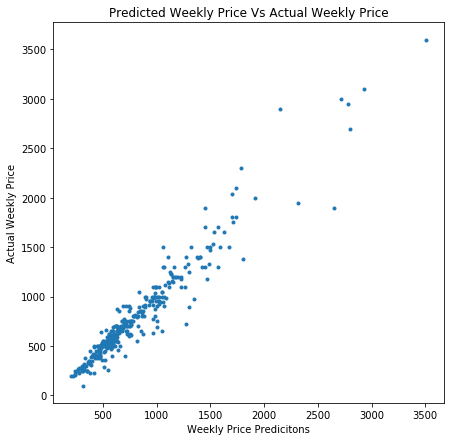

In [992]:
# Testing predictions and plotting for visualization
print(ens_reg.score(X_test,y_test))
plt.figure(figsize=(7,7))
plt.plot(test_preds, y_test, '.')
plt.title('Predicted Weekly Price Vs Actual Weekly Price')
plt.xlabel('Weekly Price Predicitons')
plt.ylabel('Actual Weekly Price')

###  Feature Importance <a id='Q3.1'></a>

In [993]:
# Sorting the quantitative features by feature importance.
this = dict(zip(df_num_x.columns, ens_reg.feature_importances_))
sorted_x = sorted(this.items(), key=lambda kv:kv[1], reverse=True)
sorted_dict = collections.OrderedDict(sorted_x)
pd.DataFrame(index=sorted_dict.items())

,
bedrooms,0.351840
accommodates,0.160780
latitude,0.086090
bathrooms,0.063969
longitude,0.056419
reviews_per_month,0.038292
availability_365,0.030326
host_total_listings_count,0.025400
availability_90,0.023082
host_id,0.021130


## Insights on pricing based on quantitative features:<a id='T3'></a>
1. Size and location seem to have the biggest impact on pricing.  
2. Interestingly rating and number of reviews don't impact price that much. Hosts aren't increasing the price as their reputation improves.

Future Investigation:
1. Look into pricing over time to see if there is precedent for increasing cost as rating improves and see what kind of impact that has to demand.
2. Look into the qualitative features and try to incorporate them into analysis.



# Evaluation <a id='Evaluation'></a>
The visualizations for pricing and lowest ratings based on latitude and longitude can help when deciding where to go when trying to list a new Airbnb location. The visualizations and the feature importance can help when determining what pricing should be used for the Airbnb listing. 

There are a lot of limitations on this analysis that might be answered by analysis of the qualitative features:
1. How do ratings relate to people's actual feelings when rating a Airbnb listing. For example, the lowest 10% is below a rating of 87 which feels very high.
2. Are clusters of "bad" listings due to population density or is it due to location quality? Or maybe it is just a coincidence that many "bad" listings are located by eachother.
3. Look more into what the qualitative data has to say about the listings, probably a lot of useful information that isn't being used currently.